# Asset Pricing--- Univariate Portfolio Sorts

组3 沈华傲 李林

组内成员独立完成代码并交流问题，最后合作完成展示文稿

### 1. 理论介绍
在本章中，我们深入探讨投资组合分类，这是实证资产定价中最广泛使用的统计方法之一。投资组合排序的关键应用是检查一个或多个变量是否可以预测未来的超额回报。一般来说，这个想法是将单个股票分类为投资组合，其中每个投资组合中的股票在排序变量（如公司规模）方面相似。然后，不同的投资组合代表了多样化的投资，这些投资在排序变量的水平上有所不同。然后，可以将返回分布的差异归因于排序变量的影响。我们从引入单变量投资组合排序（仅基于一个特征进行排序）开始。  
单变量投资组合排序只考虑一个排序变量xt-1,i。这里，i表示股票，t-1表明投资者在t时可观察到的特征。 
目标是评估xt-1,i和股票超额回报rt,i之间的关系，为了说明投资组合排序的工作原理，我们使用上一章中对市场β的估计作为我们的排序变量。  


#### 怎样基于历史数据估计β？
在本章节的操作中，我们对β的估计基于如下回归方程：
\begin{equation}
R_i=\alpha_i+\beta_i\times R_M+e_i
\end{equation}
其中，$R_i$为单个资产的超额收益率，$R_M$为市场超额收益率，$\alpha_i$为单个资产的异常收益率，基于单个资产时间序列数据的回归系数即为我们对单个资产$\beta_i$ 的估计，通过β绝对值大小的比较（一般为正）即可对单个资产对市场变化的敏感程度形成直观感知。

#### 如何进行单变量投资组合排序（组合分析）？
（1）计算将样本进行分组的断点值，根据不同时段排序变量X的分位数进行计算；（2）使用这些断点值对样本进行分组；（3）计算在每个组合结果变量Y的平均值；（4）检验不同组合中Y的平均值的变化情况

### 2. 前期准备
#### 2.1 导入库

In [76]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from regtabletotext import prettify_result
from scipy import stats

# 可视化
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from mizani.formatters import percent_format

import time
import warnings
warnings.filterwarnings('ignore') # 忽略警告信息

#### 2.2 数据准备
#### 我们需要哪些数据？

数据来源：

1.从factors_ff3_monthly 中获取市场超额收益的时间序列数据

2.从crsp_monthly 中获取单个公司的公司代码、所属行业及超额收益的数据

3.运行第二周代码保存beta为csv文件并读取

#### 2.2.1 导入数据

In [77]:
import os
os.chdir(r'D:\桌面\study\data\csv_exports')
factors_ff3_monthly = pd.read_csv('factors_ff3_monthly.csv')
crsp_monthly = pd.read_csv('crsp_monthly.csv')
crsp_monthly = crsp_monthly[['permno', 'month', 'ret_excess', 'mktcap_lag']]  # 选出需要的列
beta = pd.read_csv('beta_R.csv')

In [78]:
crsp_monthly

,permno,month,ret_excess,mktcap_lag
0,10000,1986-02-01 00:00:00,-0.262443,16.100000
1,10000,1986-03-01 00:00:00,0.359385,11.960000
2,10000,1986-04-01 00:00:00,-0.103792,16.330000
3,10000,1986-05-01 00:00:00,-0.227556,15.172000
4,10000,1986-06-01 00:00:00,-0.010225,11.793859
...,...,...,...,...
3326361,93436,2022-08-01 00:00:00,-0.074389,931110.623250
3326362,93436,2022-09-01 00:00:00,-0.039489,863615.620800
3326363,93436,2022-10-01 00:00:00,-0.144468,837659.500000
3326364,93436,2022-11-01 00:00:00,-0.147226,718514.868879


In [79]:
beta

,permno,month,beta_monthly,beta_daily
0,10000,1986-03-01,NaN,0.603174
1,10000,1986-04-01,NaN,0.007539
2,10000,1986-05-01,NaN,-0.051351
3,10000,1986-06-01,NaN,0.024206
4,10000,1986-07-01,NaN,0.542812
...,...,...,...,...
3336317,93436,2022-08-01,2.158801,1.793292
3336318,93436,2022-09-01,2.100328,1.548005
3336319,93436,2022-10-01,1.972512,1.262483
3336320,93436,2022-11-01,1.936273,1.411095


### 3 按市场beta排序
#### 3.1
接下来，我们将排序变量与收益率数据合并。我们使用一个月滞后beta作为排序变量以确保排序仅依赖于我们创建投资组合时可用的信息。
pd.DateOffset(months=1)：将日期增加一个月
crsp_monthly['beta_lag'] = crsp_monthly.groupby('permno')['beta'].shift(1)对于有非显式缺失值时，可能会出错。

In [80]:
beta['month'] = pd.to_datetime(beta['month'])
crsp_monthly['month'] = pd.to_datetime(crsp_monthly['month'])

beta_lag = (beta
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)
  )
  .get(["permno", "month", "beta_monthly"])
  .rename(columns={"beta_monthly": "beta_lag"})
  .dropna()
)

data_for_sorts = pd.merge(crsp_monthly, beta_lag, how="inner", on=["permno", "month"])
beta_lag['month'] = pd.to_datetime(beta_lag['month'])

计算断点，以beta_lag的中间值为断点，然后计算high和low两个投资组合的加权回报

In [81]:
breakpoint = data_for_sorts.groupby("month").median(numeric_only=True)['beta_lag']
df = pd.merge(data_for_sorts, breakpoint, how='inner', on='month')
# 按中间值分成high和low的portfolio
df['portfolio'] = 'low'
df.loc[(df['beta_lag_x'] > df['beta_lag_y']), 'portfolio'] = 'high'
df

,permno,month,ret_excess,mktcap_lag,beta_lag_x,beta_lag_y,portfolio
0,10001,1990-02-01,-0.011989,10.156125,0.097391,0.972602,low
1,10002,1990-02-01,0.014300,7.343750,0.447816,0.972602,low
2,10003,1990-02-01,0.252365,17.003500,0.848745,0.972602,low
3,10005,1990-02-01,-0.255700,0.523500,0.857188,0.972602,low
4,10009,1990-02-01,0.167377,6.116500,0.746249,0.972602,low
...,...,...,...,...,...,...,...
2117545,93105,1990-01-01,0.017922,25.590500,1.026830,0.994860,high
2117546,93113,1990-01-01,-0.033478,19.071000,0.875087,0.994860,low
2117547,93156,1990-01-01,-0.134732,120.652000,1.313054,0.994860,high
2117548,93236,1990-01-01,-0.174531,27.219500,2.025537,0.994860,high


In [82]:
beta_portfolio = df.groupby(['month','portfolio'], as_index=False).apply(lambda x: np.average(x['ret_excess'], weights=x['mktcap_lag'])) # 按市值加权
beta_portfolio.columns = ['month','portfolio','ret'] 
beta_portfolio

,month,portfolio,ret
0,1964-02-01,high,0.020540
1,1964-02-01,low,0.012402
2,1964-03-01,high,0.026461
3,1964-03-01,low,0.006701
4,1964-04-01,high,-0.019886
...,...,...,...
1409,2022-10-01,low,0.081462
1410,2022-11-01,high,0.029442
1411,2022-11-01,low,0.064781
1412,2022-12-01,high,-0.094677


### 4 表现评估
我们可以根据这两个投资组合构建一个多短期策略：购买高beta投资组合，同时做空低beta投资组合。因此，市场的整体地位净值为零，即在没有摩擦的情况下无需投资来实现这一战略。

In [83]:
beta_longshort = beta_portfolio.pivot(index = 'month', columns = "portfolio", values = "ret")
beta_longshort['long_short'] = beta_longshort['high']-beta_longshort['low']
beta_longshort

portfolio,high,low,long_short
month,,,
1964-02-01,0.020540,0.012402,0.008138
1964-03-01,0.026461,0.006701,0.019760
1964-04-01,-0.019886,0.013666,-0.033553
1964-05-01,0.014114,0.013221,0.000893
1964-06-01,0.010281,0.016303,-0.006022
...,...,...,...
2022-08-01,-0.035938,-0.042990,0.007051
2022-09-01,-0.111555,-0.080609,-0.030946
2022-10-01,0.064313,0.081462,-0.017149


我们计算平均回报和相应的标准误差，以测试多头投资组合的平均超额回报率是正还是负。在资产定价文献中，人们通常通过使用Newey和West（1987）来调整自相关性，t-statistics来测试平均投资组合超额回报等于零的原假设的统计数据。Newey-West标准错误的一个必要输入是根据用于估计的滞后数量选择带宽，研究人员通常默认选择预先指定的6个月滞后长度。

In [85]:
# 使用 statsmodels 公式 API 进行线性回归
model_fit = smf.ols('long_short ~ 1', data=beta_longshort).fit(cov_type='HAC', cov_kwds={'maxlags': 6}) # bandwith为6

# 打印回归系数及其稳健性标准误
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                nan
Time:                        22:40:00   Log-Likelihood:                 1420.5
No. Observations:                 707   AIC:                            -2839.
Df Residuals:                     706   BIC:                            -2834.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.765e-05      0.001      0.045      0.9

结果表明，我们不能拒绝平均回报等于零的原假设。因此，我们的投资组合策略使用中位数作为断点，不会产生任何异常回报。然而CAPM认为，高beta股票应该会产生更高的预期回报。我们的投资组合类型模仿了通过做空低β股票做多高β股票融资的投资策略。因此，应该期望平均超额回报会产生高于无风险利率的回报。

### 5 程序化投资组合分类
我们希望将股票分为更多的投资组合。我们定义了一个函数：用pd.qcut函数计算n_portfolios的断点。

使用该函数，根据beta_lag将股票分为十个投资组合并计算每个投资组合的加权回报。

In [91]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    # 计算分位数并分配投资组合编号
    breakpoints = pd.qcut(data[sorting_variable], q=n_portfolios, labels=False, duplicates='drop') + 1
    return breakpoints

factors_ff3_monthly['month'] = pd.to_datetime(factors_ff3_monthly['month'])
data_for_sorts['month'] = pd.to_datetime(data_for_sorts['month'])

# 1. 为每个月分配投资组合
data_for_sorts['portfolio'] = data_for_sorts.groupby('month').apply(
    lambda x: assign_portfolio(x, 'beta_lag', 10)
).reset_index(level=0, drop=True)

# 2. 计算每个投资组合每月的加权平均超额收益
grouped = data_for_sorts.groupby(['portfolio', 'month'])
beta_portfolios = grouped.apply(lambda x: pd.Series({
    'ret': np.average(x['ret_excess'], weights=x['mktcap_lag'])
})).reset_index()

# 3. 与 factors_ff3_monthly DataFrame 合并
beta_portfolios = beta_portfolios.merge(factors_ff3_monthly, how='left', on='month')

# 查看结果
beta_portfolios

,portfolio,month,ret,mkt_excess,smb,hml,rf
0,1,1964-02-01,0.005180,0.0154,0.0011,0.0281,0.0026
1,1,1964-03-01,0.011372,0.0141,0.0087,0.0340,0.0031
2,1,1964-04-01,0.028620,0.0010,-0.0135,-0.0067,0.0029
3,1,1964-05-01,0.009502,0.0142,-0.0086,0.0186,0.0026
4,1,1964-06-01,0.006619,0.0127,-0.0012,0.0062,0.0030
...,...,...,...,...,...,...,...
7065,10,2022-08-01,-0.040547,-0.0377,0.0140,0.0029,0.0019
7066,10,2022-09-01,-0.076212,-0.0935,-0.0081,0.0005,0.0019
7067,10,2022-10-01,-0.034925,0.0783,0.0006,0.0801,0.0023
7068,10,2022-11-01,-0.083902,0.0460,-0.0352,0.0138,0.0029


### 6 更多表现评估
在下一步中，我们将计算每个投资组合的汇总统计数据。也就是说，我们计算CAPM调整后的alpha、每个beta投资组合的beta和平均回报。

In [96]:
beta_portfolios_summary = (beta_portfolios
                           .groupby("portfolio",group_keys=False)
                           .apply(lambda x: x.assign(alpha=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[0],
                                                     beta=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[1],
                                                     ret=x["ret"].mean())
                                  .tail(1))
                           .get(["portfolio","alpha","beta","ret"])
                           )
beta_portfolios_summary

,portfolio,alpha,beta,ret
706,1,0.001965,0.535903,0.004872
1413,2,0.001894,0.662498,0.005487
2120,3,0.002116,0.766005,0.006271
2827,4,0.001111,0.867173,0.005815
3534,5,0.000307,0.974727,0.005594
4241,6,0.000478,1.051836,0.006183
4948,7,-0.000932,1.178395,0.005459
5655,8,-0.000951,1.268703,0.005930
6362,9,-0.002024,1.460599,0.005899
7069,10,-0.002836,1.689248,0.006327


下图说明了beta排序投资组合的CAPM的alpha。说明，低beta投资组合往往表现出正alpha，而高beta投资组合表现出负alpha。

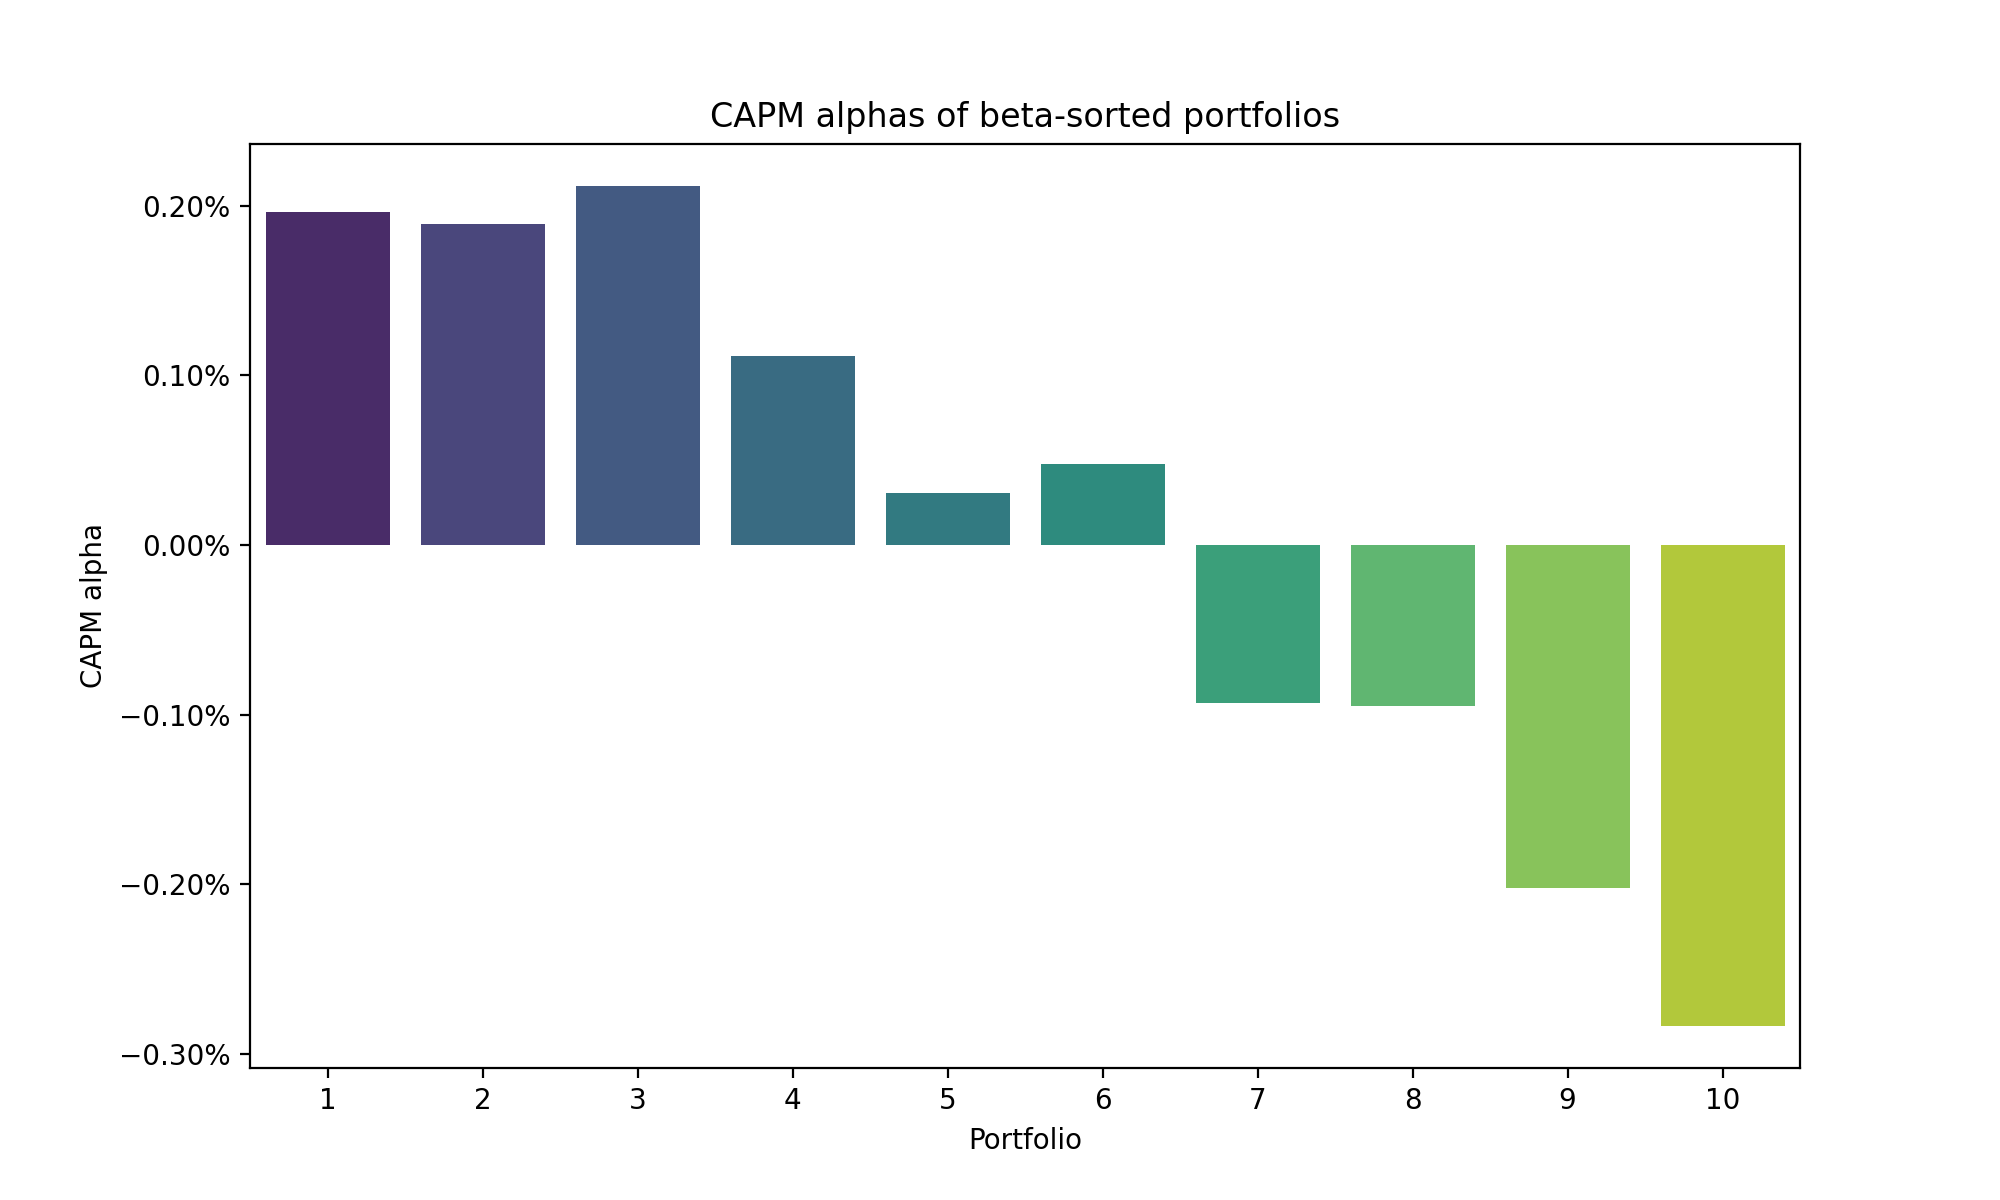

In [93]:
# 创建条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='portfolio', y='alpha', data=beta_portfolios_summary, palette='viridis')

# 设置标题和坐标轴标签
plt.title('CAPM alphas of beta-sorted portfolios')
plt.xlabel('Portfolio')
plt.ylabel('CAPM alpha')

# 设置y轴的格式为百分比
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# 移除图例
plt.legend([],[], frameon=False)

# 显示图表
plt.show()

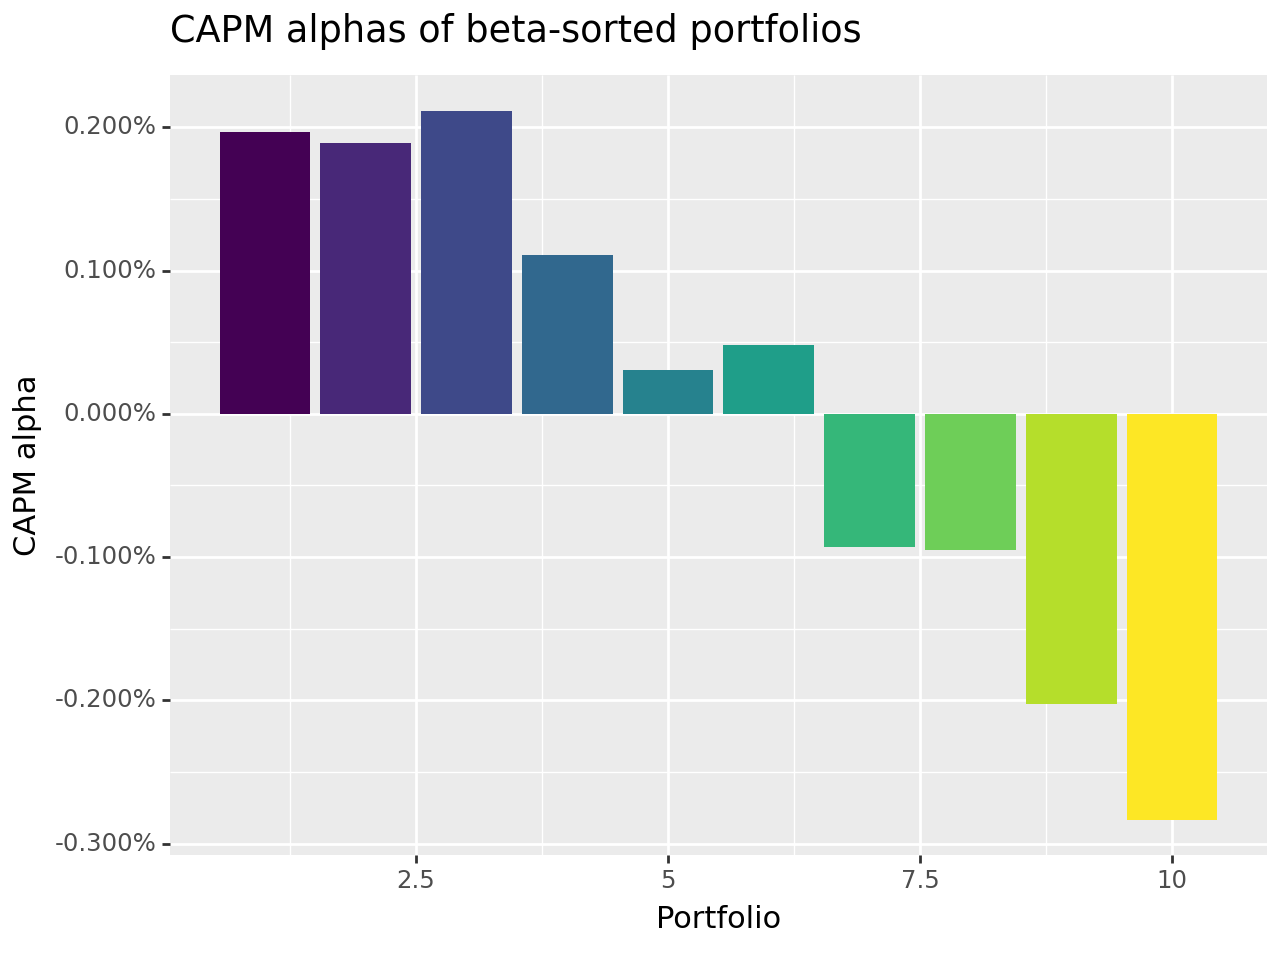

In [97]:
## 原文代码更优
plot_beta_portfolios_summary = (
  ggplot(beta_portfolios_summary, 
         aes(x="portfolio", y="alpha", fill="portfolio")) +
  geom_bar(stat="identity") +
  labs(title="CAPM alphas of beta-sorted portfolios",
       x="Portfolio", y="CAPM alpha", fill="Portfolio") +
  scale_y_continuous(labels=percent_format()) +
  theme(legend_position="none")
)
plot_beta_portfolios_summary.draw()

这些结果表明，beta和未来股票回报之间存在负面关系，这与CAPM的预测相矛盾。根据CAPM，整个投资组合的回报应该随着beta的增加而增加，风险调整后的回报应该在统计学上无法与零区分开来。

### 6 证券市场线和beta投资组合
CAPM预测，我们的投资组合应该在证券市场线（SML）上。SML的斜率等于市场风险溢价，并反映了任何给定时间的风险回报权衡。下图说明了证券市场线：我们看到（毫不奇怪）高beta投资组合回报与市场回报高度相关。然而，高贝塔股票的平均超额回报似乎低于证券市场线包含的对高市场风险的“适当”补偿。

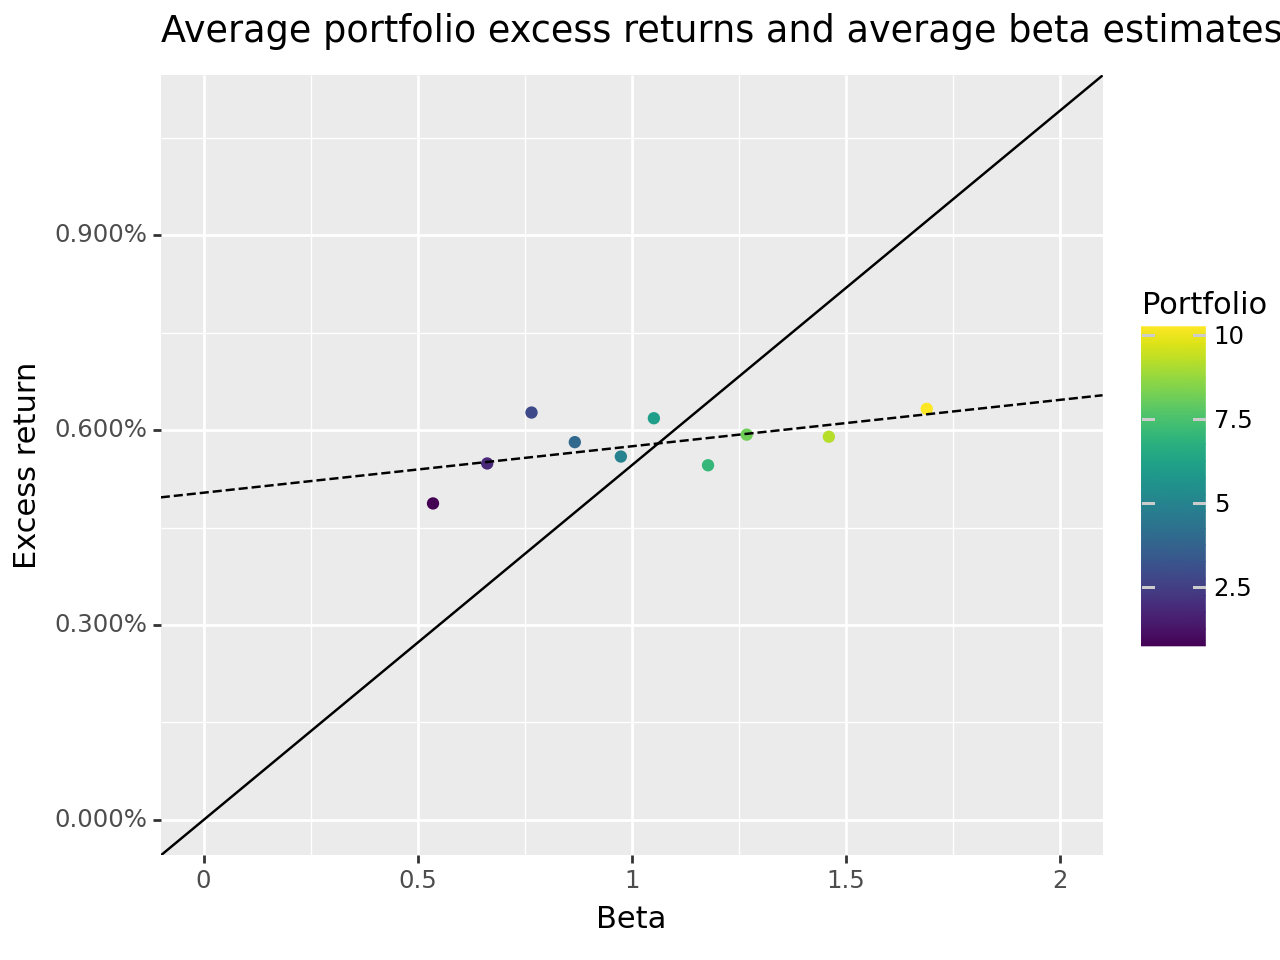

In [99]:
sml_capm = (sm.OLS.from_formula(
    formula="ret ~ 1 + beta", 
    data=beta_portfolios_summary
  )
  .fit()
  .params
)

plot_sml_capm = (
  ggplot(beta_portfolios_summary,
         aes(x="beta", y="ret", color="portfolio")) +
  geom_point() + 
  geom_abline(intercept=0,
              slope=factors_ff3_monthly["mkt_excess"].mean(),
              linetype="solid") +
  geom_abline(intercept=sml_capm["Intercept"],
                slope=sml_capm["beta"],
                linetype="dashed") +
  scale_y_continuous(
    labels=percent_format(),
    limits=(0, factors_ff3_monthly["mkt_excess"].mean()*2)
  ) +
  scale_x_continuous(limits=(0, 2)) +
  labs(x="Beta", y="Excess return", color="Portfolio",
       title= ("Average portfolio excess returns and "
               "average beta estimates"))
)
plot_sml_capm.draw()

为了提供更多证据来反对CAPM预测，我们再次形成了一个多头策略：购买高beta投资组合，做空低beta投资组合。

In [100]:
# 1. 标记投资组合为 'high' 或 'low'
beta_portfolios1['portfolio'] = beta_portfolios1['portfolio'].astype(int)
beta_portfolios1['portfolio'] = beta_portfolios1['portfolio'].apply(
    lambda x: 'high' if x == beta_portfolios1['portfolio'].max() else ('low' if x == beta_portfolios1['portfolio'].min() else x)
)

# 2. 过滤出只包含 'high' 和 'low' 的行
filtered_beta_portfolios = beta_portfolios1[beta_portfolios1['portfolio'].isin(['low', 'high'])]

# 3. 重塑数据为宽格式
pivot_beta_portfolios = filtered_beta_portfolios.pivot(index='month', columns='portfolio', values='ret_excess')

# 4. 计算 'long-short' 策略的收益
pivot_beta_portfolios['long_short'] = pivot_beta_portfolios['high'] - pivot_beta_portfolios['low']

# 5. 合并数据
beta_longshort1 = pivot_beta_portfolios.reset_index().merge(factors_ff3_monthly, how='left', on='month')
beta_longshort1.set_index('month', inplace=True)

# 查看结果
beta_longshort1

,high,low,long_short,mkt_excess,smb,hml,rf
month,,,,,,,
1964-02-01,0.036200,0.005180,0.031020,0.0154,0.0011,0.0281,0.0026
1964-03-01,0.045674,0.011372,0.034302,0.0141,0.0087,0.0340,0.0031
1964-04-01,-0.038196,0.028620,-0.066816,0.0010,-0.0135,-0.0067,0.0029
1964-05-01,0.008257,0.009502,-0.001245,0.0142,-0.0086,0.0186,0.0026
1964-06-01,0.021637,0.006619,0.015018,0.0127,-0.0012,0.0062,0.0030
...,...,...,...,...,...,...,...
2022-08-01,-0.040547,-0.024837,-0.015710,-0.0377,0.0140,0.0029,0.0019
2022-09-01,-0.076212,-0.049374,-0.026838,-0.0935,-0.0081,0.0005,0.0019
2022-10-01,-0.034925,0.078777,-0.113701,0.0783,0.0006,0.0801,0.0023


同样，由此产生的long-short策略没有表现出统计学上显著的回报。

In [101]:
# 使用 statsmodels 进行线性回归
model = smf.ols('long_short ~ 1', data=beta_longshort1).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

# 打印回归结果及其稳健性标准误
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                nan
Time:                        22:48:22   Log-Likelihood:                 795.58
No. Observations:                 707   AIC:                            -1589.
Df Residuals:                     706   BIC:                            -1585.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.003      0.455      0.6

In [102]:
prettify_result(model)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  Statistic  p-Value
Intercept     0.002       0.003      0.455    0.649

Summary statistics:
- Number of observations: 707
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic: nan on 0 and 706 DF, p-value: nan



然而，long-short投资组合产生了一个统计上显著的负CAPM调整后的alpha，尽管根据CAPM的影响，控制beta的影响后平均超额股票回报率应为零。因此，这些结果没有提供任何支持CAPM的证据。
Betting against beta相当于做空高beta股票并在低beta股票中采取（杠杆）多头头寸的策略。如果借款限制阻止投资者对SML持仓，他们反而被激励购买高beta股票，这导致此类高beta股票的价格相对较高（因此预期回报低于CAPM所表示的预期回报）。因此，Betting against beta策略通过向风险厌恶较低的资本约束投资者提供流动性中赚钱。

In [103]:
model_fit = (sm.OLS.from_formula(
    formula="long_short ~ 1 + mkt_excess", 
    data=beta_longshort1
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  Statistic  p-Value
Intercept     -0.005       0.002     -2.121    0.034
mkt_excess     1.153       0.072     16.050    0.000

Summary statistics:
- Number of observations: 707
- R-squared: 0.439, Adjusted R-squared: 0.438
- F-statistic: 257.610 on 1 and 705 DF, p-value: 0.000



下图显示了我们主要感兴趣的极端beta投资组合的年度回报。该图说明了过去几年没有一致的惊人模式——每个投资组合都表现出具有正和负年回报的时期。

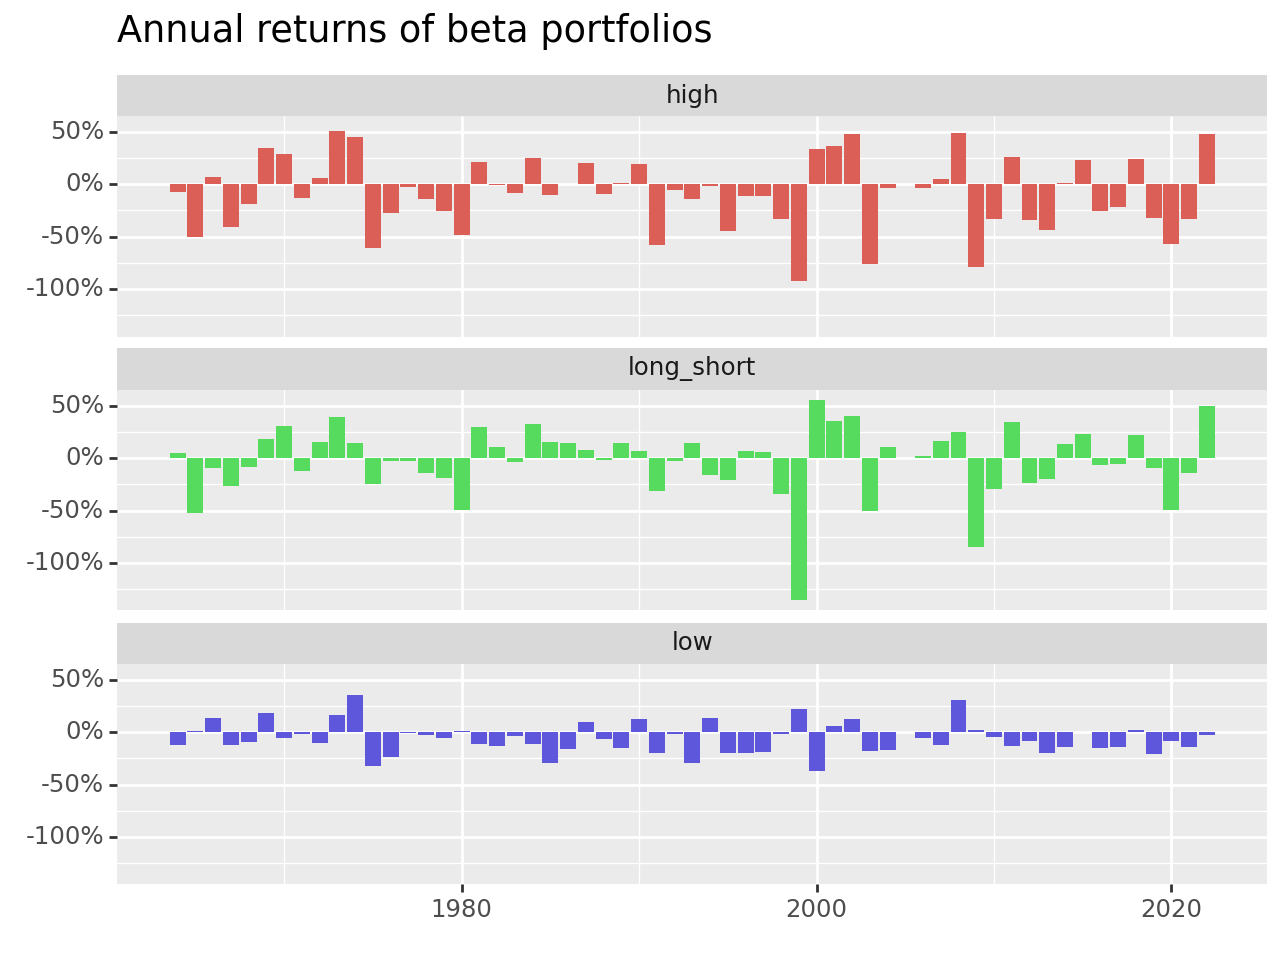

In [104]:
beta_longshort1 = beta_longshort1.reset_index()
# 1. 按年计算累积乘积
beta_longshort1['year'] = pd.to_datetime(beta_longshort1['month']).dt.year
annual_returns = beta_longshort1.groupby('year').agg(
    low=('low', lambda x: (1 + x).prod()),
    high=('high', lambda x: (1 + x).prod()),
    long_short=('long_short', lambda x: (1 + x).prod())
)

# 2. 重塑数据为长格式
annual_returns_long = pd.melt(annual_returns.reset_index(), id_vars=['year'], var_name='name', value_name='value')

plot_beta_longshort_year = (
  ggplot(annual_returns_long, 
         aes(x="year", y="1 - value", fill="name")) +  # 为什么是1-value？
  geom_col(position='dodge') +
  facet_wrap("~name", ncol=1) +
  theme(legend_position="none") +
  scale_color_discrete(guide=False) +
  scale_y_continuous(labels=percent_format()) +
  labs(x="", y="", title="Annual returns of beta portfolios")
)
plot_beta_longshort_year.draw()

1.Take the two long-short beta strategies based on different numbers of portfolios and compare the returns. Is there a significant difference in returns? How do the Sharpe ratios compare between the strategies? Find one additional portfolio evaluation statistic and compute it.

In [105]:
# 计算累积回报
cumulative_return_strategy1 = (1 + beta_longshort['long_short']).cumprod().iloc[-1] - 1
cumulative_return_strategy2 = (1 + beta_longshort1['long_short']).cumprod().iloc[-1] - 1

# 比较回报
t_stat, p_value = stats.ttest_ind(beta_longshort['long_short'].dropna(), beta_longshort1['long_short'].dropna())

# 显示结果
print("策略1 累积回报:", cumulative_return_strategy1)
print("策略2 累积回报:", cumulative_return_strategy2)
print("t检验统计量:", t_stat)
print("p值:", p_value)

# 检验是否显著
if p_value < 0.05:
    print("两种策略回报存在显著差异。")
else:
    print("两种策略回报不存在显著差异。")

策略1 累积回报: -0.2832725659381139
策略2 累积回报: -0.6783721812312686
t检验统计量: -0.43697047660625404
p值: 0.662199575248382
两种策略回报不存在显著差异。


In [106]:
# 每个strategy计算一个夏普比例直接比较
# 计算夏普比率的函数
def calculate_sharpe_ratio(excess_returns):
    return np.mean(excess_returns) / np.std(excess_returns)

# 计算两种策略的夏普比率
sharpe_ratio_strategy1 = calculate_sharpe_ratio(beta_longshort['long_short'])
sharpe_ratio_strategy2 = calculate_sharpe_ratio(beta_longshort1['long_short'])

# 显示结果
print("策略1 的夏普比率:", sharpe_ratio_strategy1)
print("策略2 的夏普比率:", sharpe_ratio_strategy2)

# 比较夏普比率
if sharpe_ratio_strategy1 > sharpe_ratio_strategy2:
    print("策略1 的风险调整回报更高。")
elif sharpe_ratio_strategy1 < sharpe_ratio_strategy2:
    print("策略2 的风险调整回报更高。")
else:
    print("两种策略的风险调整回报相同。")

策略1 的夏普比率: 0.0017765800987847005
策略2 的夏普比率: 0.018528089801434573
策略2 的风险调整回报更高。


In [107]:
# 用滚动窗口计算夏普比率，用统计意义上比较夏普比率
beta_longshort1.set_index('month', inplace=True)

# 设置滚动窗口大小（一年）
window_size = 12

# 计算年化收益率和标准差
def annualized_metrics(returns):
    annualized_return = (1 + returns).rolling(window=window_size).apply(lambda x: x.prod())**(12/window_size) - 1
    annualized_std = returns.rolling(window=window_size).std() * (12**0.5)
    return annualized_return, annualized_std

# 计算年化收益率和标准差
annualized_return1, annualized_std1 = annualized_metrics(beta_longshort['long_short'])
annualized_return2, annualized_std2 = annualized_metrics(beta_longshort1['long_short'])

# 计算Sharpe比率
sharpe_ratio1 = (annualized_return1) / annualized_std1
sharpe_ratio2 = (annualized_return2) / annualized_std2
sharpe_ratio_compare = sharpe_ratio1-sharpe_ratio2 
sharpe_ratio_compare = sharpe_ratio_compare.dropna()
sharpe_ratio_compare

month
1965-01-01   -0.643720
1965-02-01   -0.601414
1965-03-01   -0.830283
1965-04-01   -0.927054
1965-05-01   -1.198856
                ...   
2022-08-01    0.341633
2022-09-01    0.187388
2022-10-01    0.122335
2022-11-01    0.013341
2022-12-01    0.053717
Name: long_short, Length: 696, dtype: float64

In [108]:
sharpe_ratio_fit = (sm.OLS.from_formula(
    formula="sharpe_ratio_compare ~ 1", 
    data=sharpe_ratio_compare
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(sharpe_ratio_fit)

OLS Model:
sharpe_ratio_compare ~ 1

Coefficients:
           Estimate  Std. Error  Statistic  p-Value
Intercept     0.007       0.031      0.218    0.827

Summary statistics:
- Number of observations: 696
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic: nan on 0 and 695 DF, p-value: nan



Calmar比率是一种衡量投资表现的指标，特别是在考虑投资风险时。它是年化收益率与最大回撤之间的比率。Calmar比率越高，意味着投资回报相对于其风险（即最大回撤）越好。Calmar比率的计算公式为：

Calmar比率=年化收益率/最大回撤

其中最大回撤是指投资组合价值从峰值下降到谷底的最大幅度下降。

In [109]:
def calculate_max_drawdown(returns_series):
    """
    计算最大回撤
    :param returns_series: Pandas Series，包含收益率数据
    :return: 最大回撤
    """
    wealth_index = (1 + returns_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdown.min()
    return max_drawdown

def calculate_calmar_ratio(returns_series):
    """
    计算Calmar比率
    :param returns_series: Pandas Series，包含收益率数据
    :return: Calmar比率
    """
    annualized_return = (1 + returns_series).prod()**(12/len(returns_series)) - 1
    max_drawdown = calculate_max_drawdown(returns_series)
    calmar_ratio = annualized_return / -max_drawdown
    return calmar_ratio

calmar_ratio1 = calculate_calmar_ratio(beta_longshort['long_short'])
calmar_ratio2 = calculate_calmar_ratio(beta_longshort1['long_short'])
print("Calmar比率1:", calmar_ratio1)
print("Calmar比率2:", calmar_ratio2)

Calmar比率1: -0.008677346757029105
Calmar比率2: -0.021051971302895954


2.We plotted the alphas of the ten beta portfolios above. Write a function that tests these estimates for significance. Which portfolios have significant alphas?

In [111]:
alpha_test = (beta_portfolios
  .groupby("portfolio", group_keys=False)
  .apply(lambda x: x.assign(
    alpha=sm.OLS.from_formula(
      formula="ret ~ 1 + mkt_excess", 
      data=x
      ).fit().params[0],
    alpha_pvalue=sm.OLS.from_formula(
      formula="ret ~ 1 + mkt_excess", 
      data=x
      ).fit().pvalues[0]
    ).tail(1)
  .get(["portfolio","alpha","alpha_pvalue"])
  .reset_index(drop=True) 
)
)
alpha_test

,portfolio,alpha,alpha_pvalue
0,1,0.001965,0.057545
0,2,0.001894,0.018965
0,3,0.002116,0.005573
0,4,0.001111,0.111404
0,5,0.000307,0.639774
0,6,0.000478,0.491948
0,7,-0.000932,0.186082
0,8,-0.000951,0.229428
0,9,-0.002024,0.078673
0,10,-0.002836,0.076069


3.The analysis here is based on betas from monthly returns. However, we also computed betas from daily returns. Re-run the analysis and point out differences in the results.

In [113]:
beta_lag_daily = (beta
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)
  )
  .get(["permno", "month", "beta_daily"])
  .rename(columns={"beta_daily": "beta_lag"})
  .dropna()
)

data_for_sorts_daily = pd.merge(crsp_monthly, beta_lag_daily, how="inner", on=["permno", "month"])

In [114]:
data_for_sorts_daily

,permno,month,ret_excess,mktcap_lag,beta_lag
0,10000,1986-04-01,-0.103792,16.330000,0.603174
1,10000,1986-05-01,-0.227556,15.172000,0.007539
2,10000,1986-06-01,-0.010225,11.793859,-0.051351
3,10000,1986-07-01,-0.086008,11.734594,0.024206
4,10000,1986-08-01,-0.619985,10.786344,0.542812
...,...,...,...,...,...
3258588,93436,2022-08-01,-0.074389,931110.623250,2.136218
3258589,93436,2022-09-01,-0.039489,863615.620800,1.793292
3258590,93436,2022-10-01,-0.144468,837659.500000,1.548005
3258591,93436,2022-11-01,-0.147226,718514.868879,1.262483


In [115]:
breakpoint_daily = data_for_sorts_daily.groupby("month").median(numeric_only=True)['beta_lag']
df_daily = pd.merge(data_for_sorts_daily, breakpoint_daily, how='inner', on='month')
# 按中间值分成high和low的portfolio
df_daily['portfolio'] = 'low'
df_daily.loc[(df_daily['beta_lag_x'] > df_daily['beta_lag_y']), 'portfolio'] = 'high'
df_daily

,permno,month,ret_excess,mktcap_lag,beta_lag_x,beta_lag_y,portfolio
0,10000,1986-04-01,-0.103792,16.330000,0.603174,0.429627,high
1,10001,1986-04-01,0.004701,6.217812,0.029461,0.429627,low
2,10002,1986-04-01,0.047663,16.670313,-0.260756,0.429627,low
3,10003,1986-04-01,-0.067700,41.800000,1.693455,0.429627,high
4,10005,1986-04-01,0.050356,1.309219,-0.783815,0.429627,low
...,...,...,...,...,...,...,...
3258588,93423,2022-12-01,-0.038169,2003.252143,1.591693,0.881980,high
3258589,93426,2022-12-01,-0.050626,509.194066,0.803664,0.881980,low
3258590,93429,2022-12-01,-0.014101,13455.440492,0.411024,0.881980,low
3258591,93434,2022-12-01,0.339042,47.311531,1.480377,0.881980,high


In [116]:
beta_portfolio_daily = df_daily.groupby(['month','portfolio'], as_index=False).apply(lambda x: np.average(x['ret_excess'], weights=x['mktcap_lag']))
beta_portfolio_daily.columns = ['month','portfolio','ret'] 
beta_portfolio_daily

,month,portfolio,ret
0,1960-04-01,high,-0.022646
1,1960-04-01,low,-0.001892
2,1960-05-01,high,0.035021
3,1960-05-01,low,0.021438
4,1960-06-01,high,0.011814
...,...,...,...
1501,2022-10-01,low,0.107290
1502,2022-11-01,high,0.047423
1503,2022-11-01,low,0.044337
1504,2022-12-01,high,-0.086214


In [117]:
beta_longshort_daily = beta_portfolio_daily.pivot(index = 'month', columns = "portfolio", values = "ret")
beta_longshort_daily['long_short'] = beta_longshort_daily['high']-beta_longshort_daily['low']
beta_longshort_daily

portfolio,high,low,long_short
month,,,
1960-04-01,-0.022646,-0.001892,-0.020754
1960-05-01,0.035021,0.021438,0.013583
1960-06-01,0.011814,0.039254,-0.027440
1960-07-01,-0.024771,-0.021321,-0.003451
1960-08-01,0.018982,0.049958,-0.030975
...,...,...,...
2022-08-01,-0.044876,-0.029655,-0.015222
2022-09-01,-0.111182,-0.070795,-0.040387
2022-10-01,0.053572,0.107290,-0.053718


In [118]:
# 使用 statsmodels 公式 API 进行线性回归
model_fit = smf.ols('long_short ~ 1', data=beta_longshort_daily).fit(cov_type='HAC', cov_kwds={'maxlags': 6}) # bandwith为6

# 打印回归系数及其稳健性标准误
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Dec 2023   Prob (F-statistic):                nan
Time:                        22:50:36   Log-Likelihood:                 1570.6
No. Observations:                 753   AIC:                            -3139.
Df Residuals:                     752   BIC:                            -3135.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.001     -0.502      0.6

In [120]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    # 计算分位数并分配投资组合编号
    breakpoints = pd.qcut(data[sorting_variable], q=n_portfolios, labels=False, duplicates='drop') + 1
    return breakpoints

data_for_sorts_daily['month'] = pd.to_datetime(data_for_sorts_daily['month'])

# 1. 为每个月分配投资组合
data_for_sorts_daily['portfolio'] = data_for_sorts_daily.groupby('month').apply(
    lambda x: assign_portfolio(x, 'beta_lag', 10)
).reset_index(level=0, drop=True)

# 2. 计算每个投资组合每月的加权平均超额收益
grouped_daily = data_for_sorts_daily.groupby(['portfolio', 'month'])
beta_portfolios_daily = grouped_daily.apply(lambda x: pd.Series({
    'ret': np.average(x['ret_excess'], weights=x['mktcap_lag'])
})).reset_index()

# 3. 与 factors_ff3_monthly DataFrame 合并
beta_portfolios_daily = beta_portfolios_daily.merge(factors_ff3_monthly, how='left', on='month')

# 查看结果
print(beta_portfolios_daily)

      portfolio      month       ret  mkt_excess     smb     hml      rf
0             1 1960-04-01  0.006148     -0.0171  0.0032 -0.0228  0.0019
1             1 1960-05-01  0.008802      0.0312  0.0121 -0.0370  0.0027
2             1 1960-06-01  0.036448      0.0208 -0.0021 -0.0034  0.0024
3             1 1960-07-01 -0.020204     -0.0237 -0.0051  0.0198  0.0013
4             1 1960-08-01  0.045794      0.0301  0.0087 -0.0018  0.0017
...         ...        ...       ...         ...     ...     ...     ...
7525         10 2022-08-01 -0.058108     -0.0377  0.0140  0.0029  0.0019
7526         10 2022-09-01 -0.105242     -0.0935 -0.0081  0.0005  0.0019
7527         10 2022-10-01  0.047554      0.0783  0.0006  0.0801  0.0023
7528         10 2022-11-01  0.073233      0.0460 -0.0352  0.0138  0.0029
7529         10 2022-12-01 -0.127578     -0.0641 -0.0069  0.0137  0.0033

[7530 rows x 7 columns]


In [122]:
# 1. 定义执行线性回归的函数
def run_regression(group):
    model = LinearRegression()
    X = group[['mkt_excess']]  # 作为自变量
    y = group['ret']           # 作为因变量
    model.fit(X, y)
    alpha = model.intercept_
    beta = model.coef_[0]
    return pd.Series({'alpha': alpha, 'beta': beta, 'ret': group['ret'].mean()})

# 3. 对每个投资组合执行线性回归并计算平均收益率
beta_portfolios_summary_daily = beta_portfolios_daily.groupby('portfolio').apply(run_regression).reset_index()

# 查看结果
print(beta_portfolios_summary_daily)

   portfolio     alpha      beta       ret
0          1 -0.000717  0.690143  0.003132
1          2  0.002530  0.648492  0.006147
2          3  0.002033  0.706990  0.005976
3          4  0.001463  0.769359  0.005754
4          5  0.001947  0.824251  0.006544
5          6  0.000804  0.882538  0.005726
6          7  0.000884  1.003180  0.006479
7          8 -0.000763  1.103506  0.005392
8          9 -0.002348  1.272655  0.004751
9         10 -0.005395  1.608707  0.003578


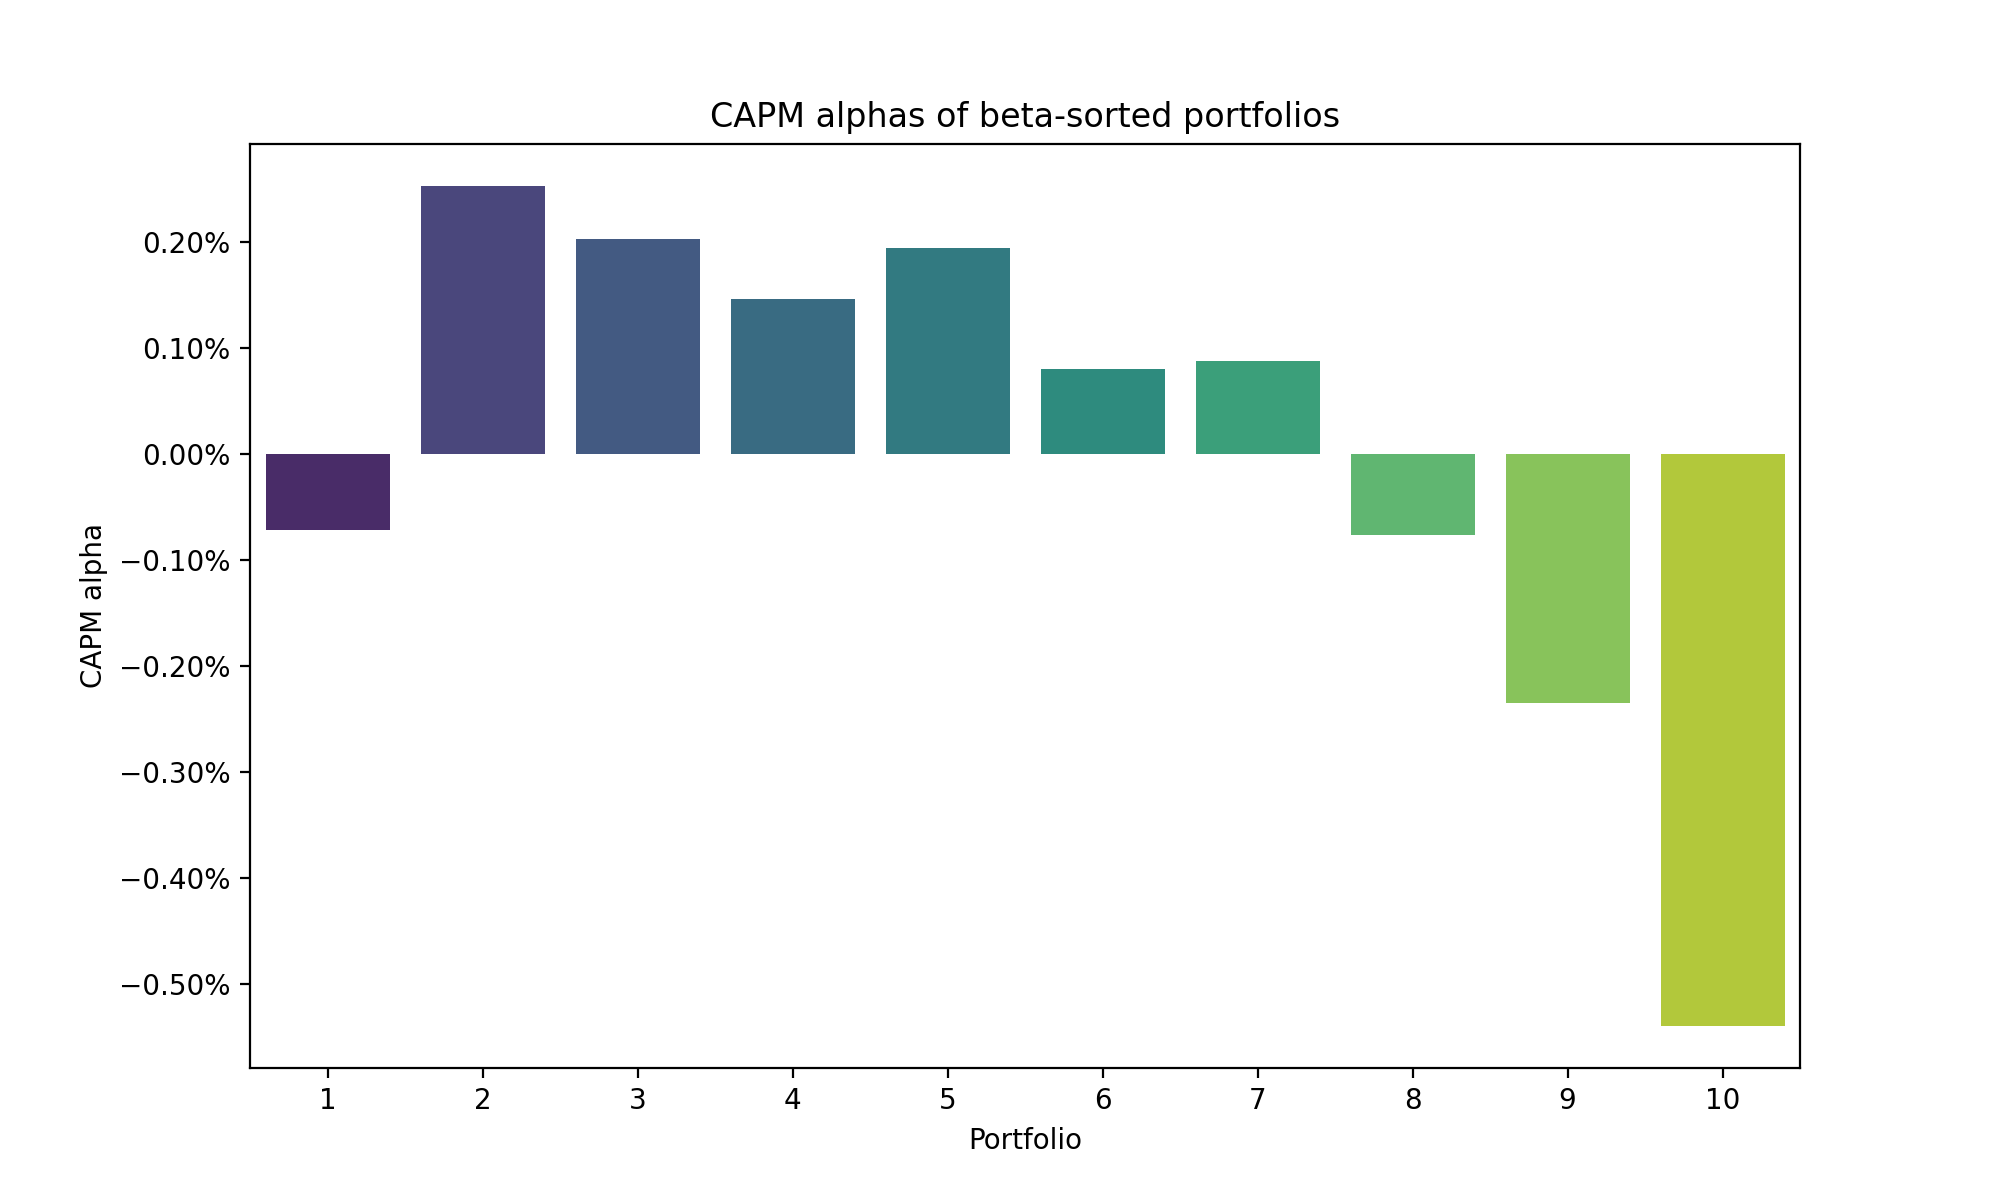

In [123]:
# 创建条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='portfolio', y='alpha', data=beta_portfolios_summary_daily, palette='viridis')

# 设置标题和坐标轴标签
plt.title('CAPM alphas of beta-sorted portfolios')
plt.xlabel('Portfolio')
plt.ylabel('CAPM alpha')

# 设置y轴的格式为百分比
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# 移除图例
plt.legend([],[], frameon=False)

# 显示图表
plt.show()

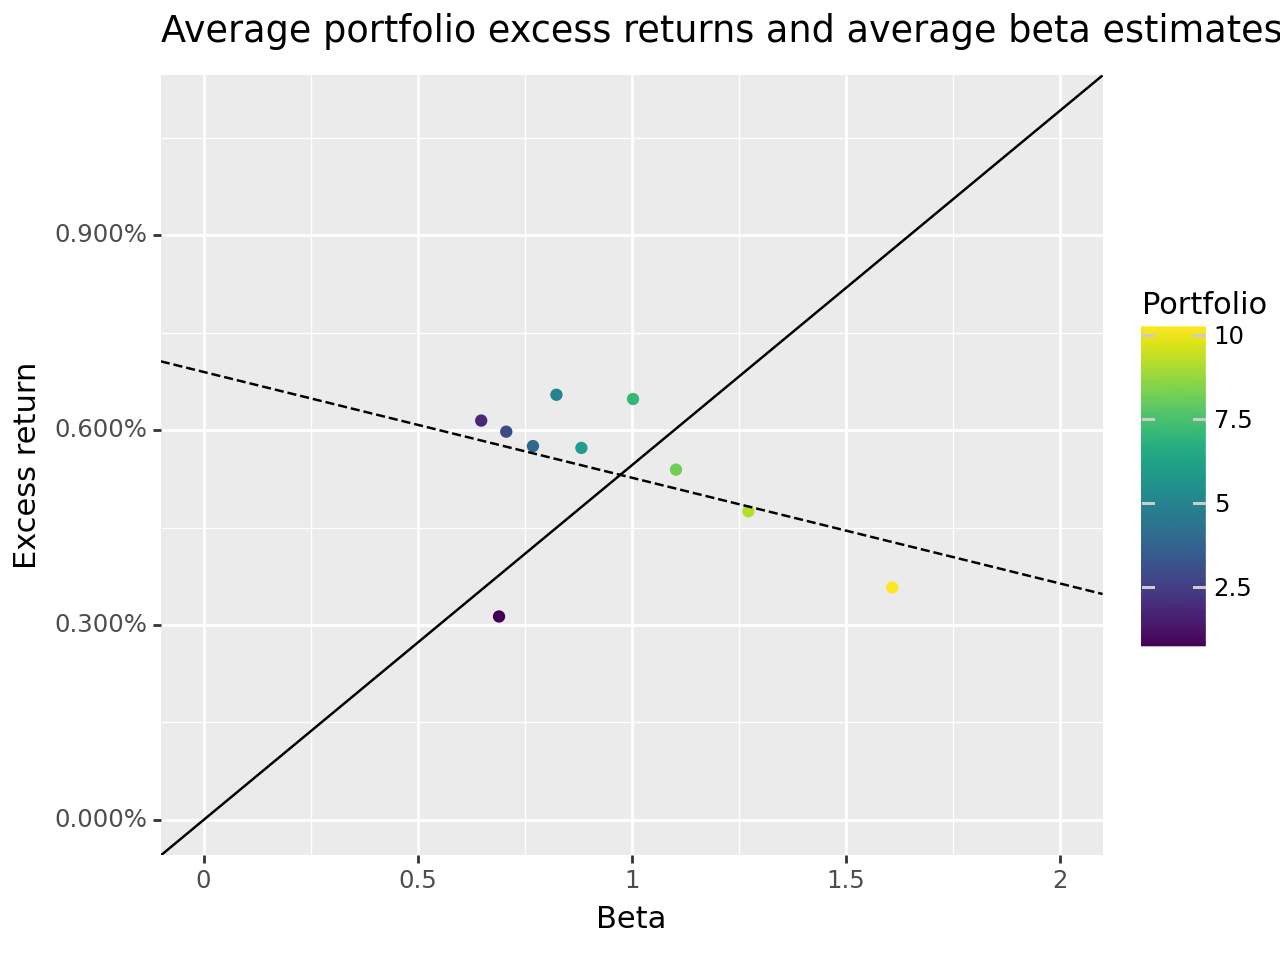

In [124]:
sml_capm = (sm.OLS.from_formula(
    formula="ret ~ 1 + beta", 
    data=beta_portfolios_summary_daily
  )
  .fit()
  .params
)

plot_sml_capm = (
  ggplot(beta_portfolios_summary_daily,
         aes(x="beta", y="ret", color="portfolio")) +
  geom_point() + 
  geom_abline(intercept=0,
              slope=factors_ff3_monthly["mkt_excess"].mean(),
              linetype="solid") +
  geom_abline(intercept=sml_capm["Intercept"],
                slope=sml_capm["beta"],
                linetype="dashed") +
  scale_y_continuous(
    labels=percent_format(),
    limits=(0, factors_ff3_monthly["mkt_excess"].mean()*2)
  ) +
  scale_x_continuous(limits=(0, 2)) +
  labs(x="Beta", y="Excess return", color="Portfolio",
       title= ("Average portfolio excess returns and "
               "average beta estimates"))
)
plot_sml_capm.draw()

In [129]:
# 1. 标记投资组合为 'high' 或 'low'
beta_portfolios_daily['portfolio'] = beta_portfolios_daily['portfolio'].astype(str).astype(int)
beta_portfolios_daily['portfolio'] = beta_portfolios_daily['portfolio'].apply(
    lambda x: 'high' if x == beta_portfolios_daily['portfolio'].max() else ('low' if x == beta_portfolios_daily['portfolio'].min() else x)
)

# 2. 过滤出只包含 'high' 和 'low' 的行
filtered_beta_portfolios = beta_portfolios_daily[beta_portfolios_daily['portfolio'].isin(['low', 'high'])]

# 3. 重塑数据为宽格式
pivot_beta_portfolios = filtered_beta_portfolios.pivot(index='month', columns='portfolio', values='ret')

# 4. 计算 'long-short' 策略的收益
pivot_beta_portfolios['long_short'] = pivot_beta_portfolios['high'] - pivot_beta_portfolios['low']

# 5. 合并数据
beta_longshort1_daily = pivot_beta_portfolios.reset_index().merge(factors_ff3_monthly, how='left', on='month')
beta_longshort1_daily.set_index('month', inplace=True)

# 查看结果
beta_longshort1_daily

,high,low,long_short,mkt_excess,smb,hml,rf
month,,,,,,,
1960-04-01,-0.023305,0.006148,-0.029454,-0.0171,0.0032,-0.0228,0.0019
1960-05-01,0.050971,0.008802,0.042169,0.0312,0.0121,-0.0370,0.0027
1960-06-01,-0.000617,0.036448,-0.037065,0.0208,-0.0021,-0.0034,0.0024
1960-07-01,-0.043013,-0.020204,-0.022810,-0.0237,-0.0051,0.0198,0.0013
1960-08-01,0.012240,0.045794,-0.033554,0.0301,0.0087,-0.0018,0.0017
...,...,...,...,...,...,...,...
2022-08-01,-0.058108,-0.001206,-0.056902,-0.0377,0.0140,0.0029,0.0019
2022-09-01,-0.105242,-0.006704,-0.098538,-0.0935,-0.0081,0.0005,0.0019
2022-10-01,0.047554,0.010704,0.036850,0.0783,0.0006,0.0801,0.0023


In [130]:
# 使用 statsmodels 进行线性回归
model = smf.ols('long_short ~ 1', data=beta_longshort1_daily).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# 打印回归结果及其稳健性标准误
prettify_result(model)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  Statistic  p-Value
Intercept       0.0       0.003      0.177    0.859

Summary statistics:
- Number of observations: 753
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic: nan on 0 and 752 DF, p-value: nan



In [131]:
model_fit = (sm.OLS.from_formula(
    formula="long_short ~ 1 + mkt_excess", 
    data=beta_longshort1_daily
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  Statistic  p-Value
Intercept     -0.005       0.002     -2.054     0.04
mkt_excess     0.919       0.081     11.388     0.00

Summary statistics:
- Number of observations: 753
- R-squared: 0.344, Adjusted R-squared: 0.343
- F-statistic: 129.689 on 1 and 751 DF, p-value: 0.000



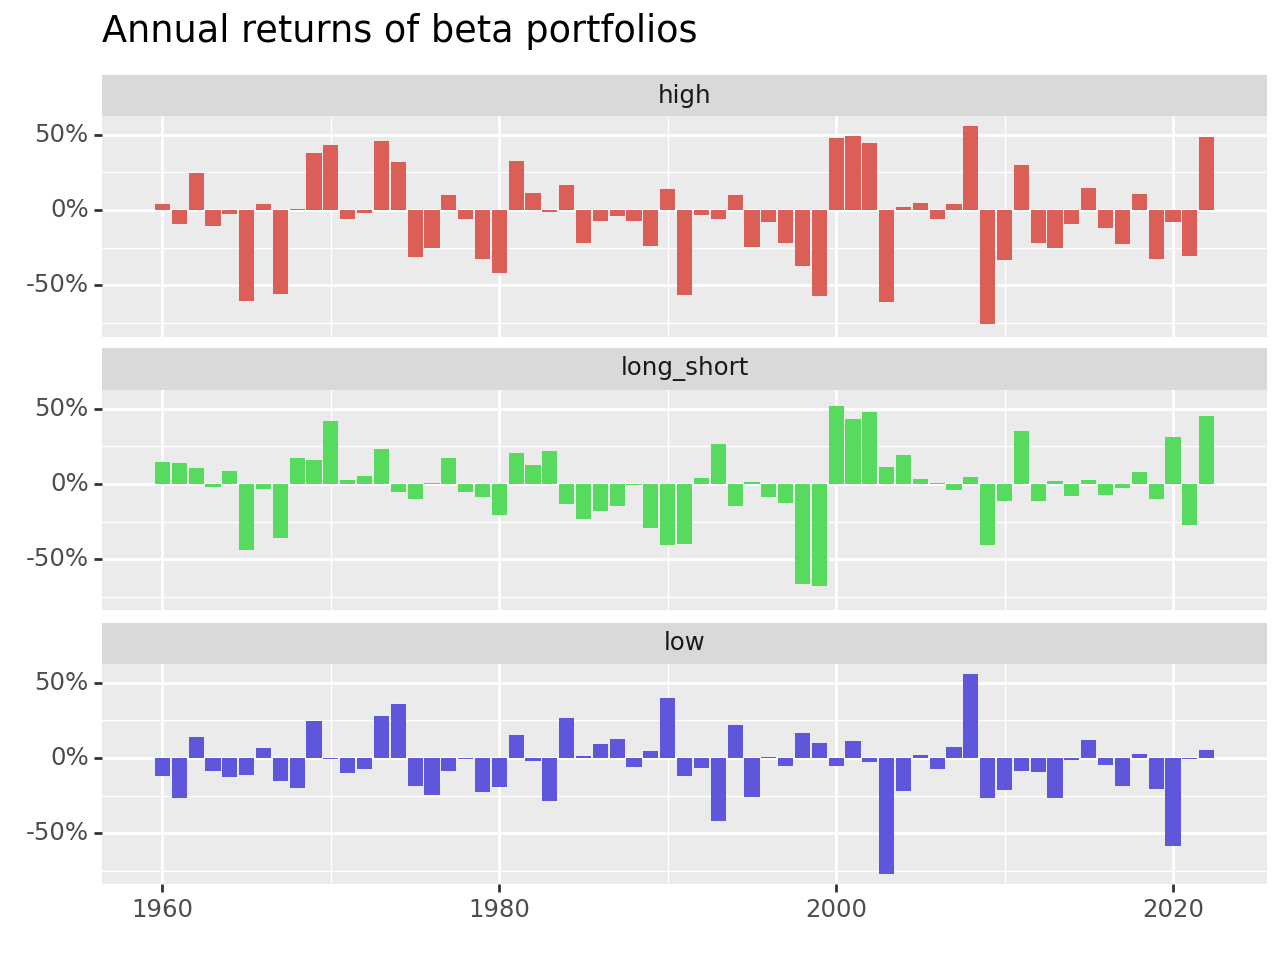

In [132]:
beta_longshort1_daily = beta_longshort1_daily.reset_index()
# 1. 按年计算累积乘积
beta_longshort1_daily['year'] = pd.to_datetime(beta_longshort1_daily['month']).dt.year
annual_returns = beta_longshort1_daily.groupby('year').agg(
    low=('low', lambda x: (1 + x).prod()),
    high=('high', lambda x: (1 + x).prod()),
    long_short=('long_short', lambda x: (1 + x).prod())
)

# 2. 重塑数据为长格式
annual_returns_long = pd.melt(annual_returns.reset_index(), id_vars=['year'], var_name='name', value_name='value')

plot_beta_longshort_year = (
  ggplot(annual_returns_long, 
         aes(x="year", y="1 - value", fill="name")) +  
  geom_col(position='dodge') +
  facet_wrap("~name", ncol=1) +
  theme(legend_position="none") +
  scale_color_discrete(guide=False) +
  scale_y_continuous(labels=percent_format()) +
  labs(x="", y="", title="Annual returns of beta portfolios")
)
plot_beta_longshort_year.draw()

4.Given the results in this chapter, can you define a long-short strategy that yields positive abnormal returns (i.e., alphas)? Plot the cumulative excess return of your strategy and the market excess return for comparison.

要让long_short～1+mkt_excess的截距项显著且大于0，感觉不能通过beta分层，要么构造别的因子，要么选用多种资产构造

尝试了分更多层和percentile(0, 0.3, 0.7, 1)等分层方式均不成功，mktcap_lag等因子分层也不成功

最终选用夏普比率

In [134]:
#定义夏普比率计算函数
def sharpe_ratio(ret_excess):
    ret_excess_mean = np.mean(ret_excess)
    ret_excess_sd = np.std(ret_excess)
    sharpe_ratio = ret_excess_mean/ret_excess_sd
    return sharpe_ratio

#以一年作为计算的窗口期
window_size = 12

#滚动计算夏普比率
sharpe = (crsp_monthly
        .get(["permno","month","ret_excess"])
        .assign(sharpe_ratio=lambda x: x["ret_excess"].rolling(window = window_size).apply(lambda y: sharpe_ratio(y)))
        .dropna()
        )
sharpe

,permno,month,ret_excess,sharpe_ratio
11,10000,1987-01-01,-0.216321,-0.648728
12,10000,1987-02-01,-0.004300,-0.554445
13,10000,1987-03-01,-0.389315,-1.010305
14,10000,1987-04-01,-0.066900,-0.985261
15,10000,1987-05-01,-0.070467,-0.906140
...,...,...,...,...
3326361,93436,2022-08-01,-0.074389,0.134175
3326362,93436,2022-09-01,-0.039489,0.093314
3326363,93436,2022-10-01,-0.144468,-0.203407
3326364,93436,2022-11-01,-0.147226,-0.296549


In [135]:
#将夏普比率滞后一期，作为分组的排序变量
sharpe_lag = (sharpe
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)  
  )
  .get(["permno", "month", "sharpe_ratio"])
  .rename(columns={"sharpe_ratio": "sharpe_lag"})
  .dropna()
)

data_for_sorts_new = (crsp_monthly
  .merge(sharpe_lag, 
         how="inner", 
         on=["permno", "month"])
)
data_for_sorts_new

,permno,month,ret_excess,mktcap_lag,sharpe_lag
0,10000,1987-02-01,-0.004300,1.581531,-0.648728
1,10000,1987-03-01,-0.389315,1.581531,-0.554445
2,10000,1987-04-01,-0.066900,0.973250,-1.010305
3,10000,1987-05-01,-0.070467,0.912422,-0.985261
4,10001,1986-03-01,0.019200,6.156250,-0.886387
...,...,...,...,...,...
3296400,93436,2022-08-01,-0.074389,931110.623250,0.199283
3296401,93436,2022-09-01,-0.039489,863615.620800,0.134175
3296402,93436,2022-10-01,-0.144468,837659.500000,0.093314
3296403,93436,2022-11-01,-0.147226,718514.868879,-0.203407


In [136]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    breakpoints = np.quantile(
      data[sorting_variable].dropna(), 
      np.linspace(0, 1, n_portfolios + 1),
      method="linear" 
    )
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=range(1, breakpoints.size), 
      include_lowest=True   
    )
    
    return assigned_portfolios

In [137]:
#根据滞后的夏普比率进行分组
sharpe_portfolios = (data_for_sorts_new
  .groupby("month", group_keys=False)
  .apply(lambda x: x.assign(
    portfolio = assign_portfolio(x, 'sharpe_lag', 10)
    )
  )
  .groupby(["portfolio", "month"], group_keys=False)
  .apply(lambda x: x.assign(
    ret=np.average(x["ret_excess"], weights=x["mktcap_lag"])
    )  
  )
)

In [138]:
#构建新的多空投资组合
sharpe_longshort_new = (sharpe_portfolios
  .assign(
    portfolio=lambda x: (
      x["portfolio"].apply(
        lambda y: "high" if y == x["portfolio"].max()
        else ("low" if y == x["portfolio"].min()
        else y)
      )
    )
  )
  .query("portfolio in ['low', 'high']")
  .pivot_table(index="month", 
               columns="portfolio", 
               values="ret")
  .assign(long_short_new=lambda x: x["high"] - x["low"])
  .merge(factors_ff3_monthly, how="left", on="month")
)

In [139]:
#估计新的投资组合的alpha
model_fit = (sm.OLS.from_formula(
    formula="long_short_new ~ 1 + mkt_excess", 
    data=sharpe_longshort_new
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short_new ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  Statistic  p-Value
Intercept      0.009       0.002      4.259      0.0
mkt_excess    -0.296       0.069     -4.303      0.0

Summary statistics:
- Number of observations: 754
- R-squared: 0.049, Adjusted R-squared: 0.048
- F-statistic: 18.517 on 1 and 752 DF, p-value: 0.000

